In [1]:
import hdf5storage as hdf
import tensorflow as tf
import im_model as tm
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = []
for i in range(100):
    loc = i+1
    filepath = '/home/charlieniu21/code/Deep-ADMM-Net/data/ChestTrain/im-'
    if loc < 10 :
        fp = filepath+'0'+str(loc)+'.mat'
    else:
        fp = filepath+str(loc)+'.mat'
    d = hdf.loadmat(fp)
    d_true = np.array(d['im_ori'])
    data.append(d_true)

In [3]:
mask = hdf.loadmat('/home/charlieniu21/code/Deep-ADMM-Net/mask/mask_10.mat')
mask = np.array(mask['mask'])
mask = np.fft.ifftshift(mask)
mask = np.reshape(mask, [1, 256, 256])

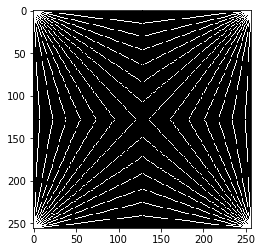

In [4]:
plt.imshow(np.reshape(mask,[256, 256]), cmap = "gray")

In [5]:
data = np.array(data)
data = np.reshape(data, [100, 256, 256, 1])

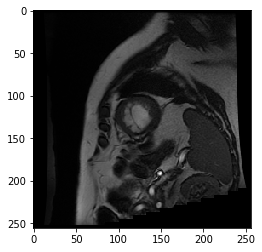

In [6]:
plt.imshow(np.reshape(data[10,:,:,:], [256, 256]), cmap = "gray")

In [7]:
def get_batch(size = 20):
    batch_loc = np.random.randint(100, size = size)
    return data[batch_loc, :, :, :]

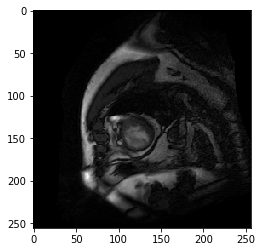

In [8]:
b1 = get_batch()
plt.imshow(np.reshape(b1[14,:,:,:], [256, 256]), cmap = "gray")

In [9]:
def get_masked(data, mask):
    with tf.device('/gpu:0'):
        d_complex = tf.reshape(tf.cast(data, tf.complex64),
                           [data.shape[0], 256, 256])
        mask_complex = tf.cast(mask, tf.complex64)
        d_kspace = tf.fft2d(d_complex)*mask_complex
        d_masked_complex = tf.ifft2d(d_kspace)
        d_masked_real = tf.reshape(tf.real(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 256, 256, 1])
        d_masked_imag = tf.reshape(tf.imag(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 256, 256, 1])
        d_masked = tf.concat([d_masked_real, d_masked_imag], axis = 3)
    with tf.Session() as sess:
        masked = sess.run(d_masked)
    return masked

In [10]:
masked = get_masked(b1, mask)

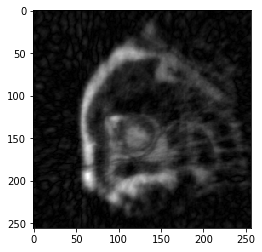

In [11]:
m1 = tf.cast(masked[14][:][:][:], tf.complex64)
re = m1[:,:,0]+1j*m1[:,:,1]
r = tf.abs(re)
r = tf.reshape(r, [256, 256])
with tf.Session() as sess:
    o1 = sess.run(r)
plt.imshow(o1, cmap = "gray")

In [12]:
batchsize = 20 # change it along with test_model.py
model_input_masked = tf.placeholder(tf.float32, [batchsize, 256, 256, 2], 
                                    "masked")
model_input_gtrue = tf.placeholder(tf.float32, [batchsize, 256, 256, 1], 
                                   "ground_truth")


In [13]:
gene_output, gene_output_complex, gene_var_list, gene_layers, disc_real_output, disc_fake_output, disc_var_list, disc_layers = tm.create_model(model_input_masked, model_input_gtrue, mask)
    
    
gene_loss, gene_dc_loss, gene_fool_loss, list_gene_lose, gene_mse_factor = tm.create_generator_loss(disc_fake_output, gene_output, gene_output_complex, model_input_masked, model_input_gtrue, mask)
    
    
disc_loss = tm.create_discriminator_loss(disc_real_output, disc_fake_output)
    
global_step, learning_rate, gene_minimize, disc_minimize = tm.create_optimizers(gene_loss, gene_var_list,disc_loss, disc_var_list)

use resnet without pooling: [128, 128, 64, 64, 16]
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
use resnet without pooling: [128, 128, 64, 64, 16]
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
use resnet without pooling: [128, 128, 64, 64, 16]
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
use resnet without pooling: [128, 128, 64, 64, 16]
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
use resnet without pooling: [128, 128, 64, 64, 16]
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
use resnet without pooling: [128, 128, 64, 64

In [14]:
import time

def train_process(epochs = 20, batch_size = 20):
    gene_train_log = []
    disc_train_log = []
    train_time = 0
    while train_time<epochs:
        start_time = time.time()
        batch_true = get_batch(batch_size)
        batch_masked = get_masked(batch_true, mask)
        g_los, d_los = sess.run([gene_loss, disc_loss],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.01})
        #print('done with loss')
        gene_train_log.append(g_los)
        disc_train_log.append(d_los)
        sess.run([gene_minimize,disc_minimize],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.01})
        print("epoch: "+str(train_time)+", g_loss: "+str(g_los)+", d_loss: "+str(d_los)+" time_spent:"+str(time.time()-start_time)+"s")
        train_time += 1
    return (gene_train_log, disc_train_log)

In [15]:
sess = tf.Session()
init = tf.global_variables_initializer()
writer = tf.summary.FileWriter("logs/", sess.graph)
sess.run(init)

In [16]:
g_log, d_log = train_process(epochs = 5)

ResourceExhaustedError: OOM when allocating tensor with shape[20,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: gene/GEN_L033/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gene/GEN_L032/Relu, gene/GEN_L033/weight/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: swap_out_gradients/Square_1_grad/Conj_0/_30 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2775_swap_out_gradients/Square_1_grad/Conj_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'gene/GEN_L033/Conv2D', defined at:
  File "/home/charlieniu21/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/charlieniu21/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/charlieniu21/anaconda3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/charlieniu21/anaconda3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/charlieniu21/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-36cae25295e9>", line 1, in <module>
    gene_output, gene_output_complex, gene_var_list, gene_layers, disc_real_output, disc_fake_output, disc_var_list, disc_layers = tm.create_model(model_input_masked, model_input_gtrue, mask)
  File "/home/charlieniu21/code/GANCS/im_model.py", line 755, in create_model
    gene_output_1, gene_var_list, gene_layers_1 = function_generator(features, features, masks, 2)
  File "/home/charlieniu21/code/GANCS/im_model.py", line 749, in <lambda>
    num_dc_layers=1, layer_output_skip=7)
  File "/home/charlieniu21/code/GANCS/im_model.py", line 633, in _generator_model_with_scale
    model.add_residual_block(nunits, mapsize=mapsize)
  File "/home/charlieniu21/code/GANCS/im_model.py", line 223, in add_residual_block
    self.add_conv2d(num_units, mapsize=mapsize, stride=1, stddev_factor=stddev_factor)
  File "/home/charlieniu21/code/GANCS/im_model.py", line 166, in add_conv2d
    padding='SAME')
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[20,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: gene/GEN_L033/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gene/GEN_L032/Relu, gene/GEN_L033/weight/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: swap_out_gradients/Square_1_grad/Conj_0/_30 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2775_swap_out_gradients/Square_1_grad/Conj_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [20]:
gene_output

<tf.Tensor 'gene/Reshape_80:0' shape=(20, 256, 256, 1) dtype=float32>